In [1]:
import sys
from pathlib import Path

sys.path.insert(0, "/share/home/ychi/dev/sperm_struct/notebooks")

import h2 as h
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from hic_basic.hicio import load_pickle, load_json
from lib.metrics import stack_contour, plate2df
from lib.plot import plot_figure_canvas
from umap import UMAP

In [2]:
bfs = (h.ddir / "Sperm_hg").with_suffix(
    ".random.dv_ft.bfs.pkl"
    )
bfs = pd.read_pickle(bfs)

silhoutte = bfs["density"].clip(upper=1).fillna(0)
if h.version == "2":
    good_samples = load_json(
        h.fig1 / f"Fig1S_structure_quality/Sperm_hg_ga.v{h.version}.json"
    )
    silhoutte = silhoutte[good_samples]
silhoutte_contour = silhoutte.apply(stack_contour, axis=0)

### dv contour before alignmetn

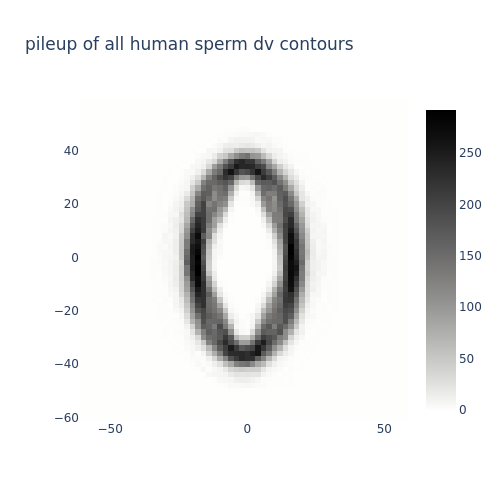

In [3]:
fig = plot_figure_canvas(
    silhoutte_contour.sum(axis=1).unstack(),
    square_size=60,
    fill=0,
    cmap="gray_r"
)
fig.update_layout(
    title = "pileup of all human sperm dv contours"
)
fig.show(renderer= "png")

### visualize using 2-component UMAP decomposition

In [4]:
#(silhoutte_contour / silhoutte_contour.mean(axis=0)).mean(axis=0)

In [5]:
umap = UMAP(
    n_components=2,
    random_state=42
)
data = silhoutte_contour / silhoutte_contour.mean(axis=0)
visualize_proj = umap.fit_transform(data.T.values)
visualize_proj = pd.DataFrame(
    visualize_proj,
    index=silhoutte_contour.columns,
    columns = ["x","y"]
)

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



add real (manually annotated) data

In [6]:
if h.version in ["0","1"]:
    # prepare manual targets
    Sperm_hg_targets = pd.read_excel(
        "../B_primary_views_pileup/targets/human sperm alignment.xlsx",
        index_col=1,
        names = ["blank", "sample_name", "ht", "comments"]
    ).drop(index="编号").drop(columns="blank")
    Sperm_hg_targets = Sperm_hg_targets.assign(
        dv = Sperm_hg_targets.apply(
            lambda row : 1 if abs(row["ht"]) == 1 else 0,
            axis = 1
        )
    )
    Sperm_hg_targets = Sperm_hg_targets.assign(
        lr = Sperm_hg_targets.apply(
            lambda row : 1 // row["ht"] if abs(row["ht"]) == 1 else 0,
            axis = 1
        )
    )
    # assign manual targets
    data = pd.concat(
        [visualize_proj, Sperm_hg_targets],
        axis = 1,
        join = "outer"
    ).loc[visualize_proj.index]
    data = data.replace(
        {
            "ht" : {
                -1 : "down",
                1 : "up",
                0 : "failed"
            },
        }
    )
    # plot umap
    fig = px.scatter(
        data,
        x="x",
        y="y",
        color = "ht",
        title="UMAP of human sperm contour, color with manual annotation",
        color_discrete_map = {
            "up" : px.colors.qualitative.Plotly[0],
            "down" : px.colors.qualitative.Plotly[1],
            "failed" : px.colors.qualitative.Plotly[4]
        }
    )
elif h.version == "2":
    # prepare a simple feature
    def line_feature(dat:pd.Series, line_pos=20):
        chunk = dat.copy()
        r_axis, t_axis = chunk.index.names
        chunk = chunk.rename("contour").reset_index()
        line_a = chunk.loc[chunk["contour"].astype(bool),:]
        line_a = line_a.loc[line_a[r_axis]==line_pos,t_axis]
        res = line_a.max() - line_a.min()
        return res
    line_feature_res = silhoutte_contour.apply(
        line_feature,
        axis=0,
        line_pos=20,
    ).rename("line_feature")
    # assign simple feature
    data = pd.concat(
        [visualize_proj, line_feature_res],
        axis = 1,
        join = "outer"
    ).loc[visualize_proj.index]
    # plot umap
    fig = px.scatter(
        data,
        x="x",
        y="y",
        color = "line_feature",
        title = "UMAP of human sperm contour, color with simple line feature",
    )

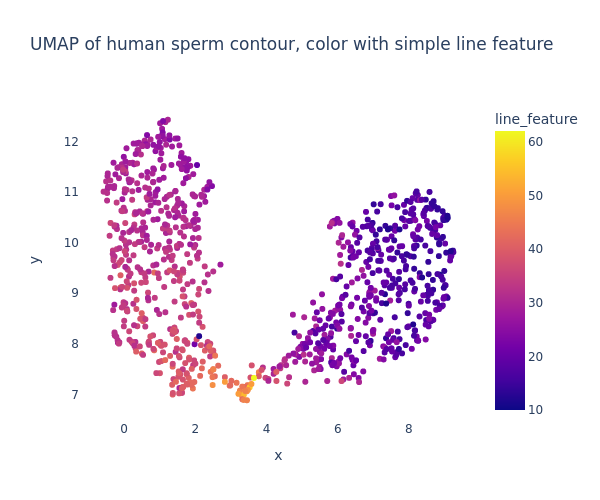

In [7]:
fig.update_layout(
    height = 500,
    width = 600,
    plot_bgcolor = "white",
)
fig.show(renderer= "png")

### clustering on 3-component UMAP

In [8]:
umap = UMAP(
    n_components=3,
    random_state=42
)
contour_proj = umap.fit_transform(silhoutte_contour.T.values)
contour_proj = pd.DataFrame(
    contour_proj,
    index=silhoutte_contour.columns,
    columns = ["x","y","z"]
)

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [9]:
from sklearn.mixture import GaussianMixture

In [10]:
gmm = GaussianMixture(
    n_components=2,
    random_state=0,
    covariance_type="full"
)
clusters = gmm.fit_predict(
    contour_proj.values,
    )

annote cluster with manmual targets

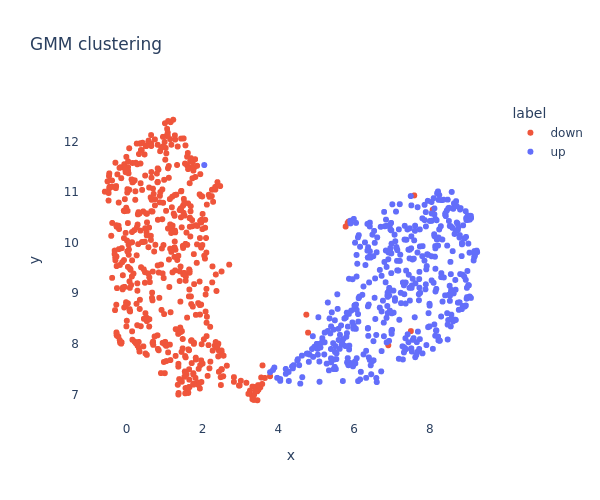

In [11]:
if h.version in ["0","1"]:
    def str_mode(x):
        return x.value_counts().idxmax()
    clusters = pd.Series(
        clusters,
        index = contour_proj.index
    )
    labels = pd.Series(
        np.zeros_like(clusters),
        dtype = "string",
        index = clusters.index
    )
    for i in clusters.unique():
        mask = (clusters == i)
        labels[mask] = str_mode(data["ht"][mask])
    # cluster visualization, just for dev
    # fig = px.scatter(
    #     visualize_proj.assign(
    #         clusters = clusters
    #     ),
    #     x="x",
    #     y="y",
    #     color = "clusters",
    #     title="UMAP of contour, GMM cluster result",
    # )
    # fig.update_layout(
    #     height = 500,
    #     width = 600,
    #     plot_bgcolor = "white",
    # )
    # fig.show(renderer= "png")

    # visualize
    fig = px.scatter(
        visualize_proj.assign(
            label = labels
        ),
        x="x",
        y="y",
        color = "label",
        title="GMM clustering",
        color_discrete_map = {
            "up" : px.colors.qualitative.Plotly[0],
            "down" : px.colors.qualitative.Plotly[1],
            "failed" : px.colors.qualitative.Plotly[4]
        }
    )
    fig.update_layout(
        height = 500,
        width = 600,
        plot_bgcolor = "white",
    )
    fig.show(renderer= "png")
elif h.version == "2":
    clusters = pd.Series(
        clusters,
        index = contour_proj.index
    )
    data = pd.concat([
        clusters.rename("clusters"),
        line_feature_res.rename("line_feature")
        ],axis=1)
    judger = data.groupby("clusters").mean()
    # init labels
    # labels is always unique set of cluster values
    labels = pd.Series(
        "failed",
        index = clusters.unique()
    )
    # for `down` contours, ht 20 feature is larger
    # change this when feature and cell type is changed
    labels.loc[
        judger.idxmax(),
    ] = "down"
    labels.loc[
        judger.idxmin(),
    ] = "up"
    clusters = pd.merge(
        pd.DataFrame(clusters.rename("cluster")),
        labels.rename("label"),
        left_on = "cluster",
        right_index = True
    )
    # visualize
    fig = px.scatter(
        visualize_proj.assign(
            label = clusters["label"]
        ),
        x="x",
        y="y",
        color = "label",
        title="GMM clustering",
        color_discrete_map = {
            "up" : px.colors.qualitative.Plotly[0],
            "down" : px.colors.qualitative.Plotly[1],
            "failed" : px.colors.qualitative.Plotly[4]
        }
    )
    fig.update_layout(
        height = 500,
        width = 600,
        plot_bgcolor = "white",
    )
    fig.show(renderer= "png")

In [13]:
visualize_proj.assign(
    label = clusters["label"]
).to_csv("Sperm_hg.round1.proj_label.csv")

In [41]:
probs = gmm.predict_proba(contour_proj.values)

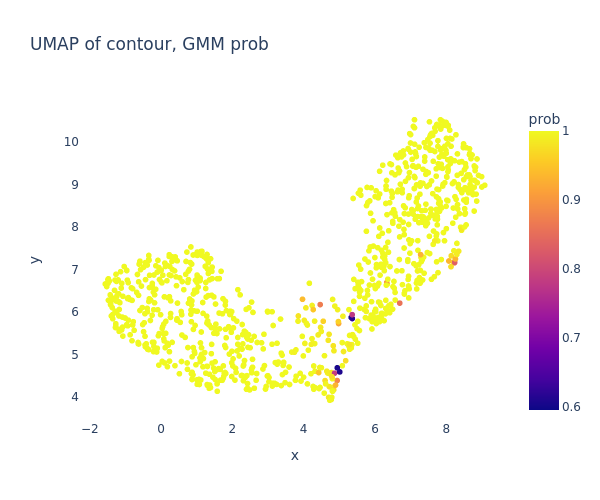

In [42]:
fig = px.scatter(
    visualize_proj.assign(
        prob = probs.max(axis=1)
    ),
    x="x",
    y="y",
    color = "prob",
    title="UMAP of contour, GMM prob",
)
fig.update_layout(
    height = 500,
    width = 600,
    plot_bgcolor = "white",
)
fig.show(renderer= "png")


### dump round1 directioning

In [12]:
if h.version in ["0","1"]:
    round1_targets = pd.DataFrame(
        {
            "ht" : labels.replace(
                {
                    "up" : "1",
                    "down" : "-1",
                    "failed" : "0"
                }
            ),
            "dv" : labels.replace(
                {
                    "up" : "1",
                    "down" : "1",
                    "failed" : "0"
                }
            ),
        }
    )
elif h.version == "2":
    round1_targets = pd.DataFrame(
        {
            "ht" : clusters["label"].replace(
                {
                    "up" : "1",
                    "down" : "-1",
                    "failed" : "0"
                }
            ),
            "dv" : clusters["label"].replace(
                {
                    "up" : "1",
                    "down" : "1",
                    "failed" : "0"
                }
            ),
        }
    )
round1_targets = round1_targets.assign(
    lr = round1_targets.apply(
        lambda row : 1 // int(row["ht"]) if int(row["ht"]) != 0 else 0,
        axis = 1
    )
)

In [14]:
round1_targets = round1_targets.astype(int)

In [15]:
round1_targets.to_csv(
    f"Sperm_hg.round1.targets.v{h.version}.csv",
    index = True
)